In [13]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

# Functions

In [15]:
def make_vote_df_from_proposal_id(proposal_id):
    url = 'https://hub.snapshot.org/graphql/'
    vote_query = create_vote_query(proposal_id)
    vote_response = requests.post(url, json={'query': vote_query})
    print(proposal_response.status_code,proposal_response.reason,proposal_id)
    vote_json = vote_response.json()
    vote_df = vote_json_to_df(vote_json)
    return vote_df
    
def create_vote_query(proposal_id):
    vote_query = '''
    query Votes {
      votes (
        first: 9999999
        skip: 0
        where: {
          proposal: "'''+ proposal_id + '''"
        }
        orderBy: "created",
        orderDirection: desc
      ) {
        id
        ipfs
        voter
        created
        space {
          id
        }
        proposal {
          id
        }
        choice
        metadata
        vp
        vp_by_strategy
        vp_state
      }
    }
    '''
    return vote_query
def vote_json_to_df(vote_json):
    row_as_series_list=[]
    for vote in vote_json['data']['votes']:
        id = vote['id']
        ipfs = vote['ipfs']
        voter = vote['voter']
        created = vote['created']
        space = vote['space']['id']
        proposal = vote['proposal']['id']
        choice = vote['choice']
        #metadata = vote['metadata']: {},
        vp = vote['vp']
        vp_by_strategy = tuple(vote['vp_by_strategy'])
        vp_state = vote['vp_state']
        row_as_series  = pd.Series(
            data=(
                id,
                ipfs,
                voter,
                created,
                space,
                proposal,
                choice,
                #metadata,
                vp,
                vp_by_strategy,
                vp_state,
                ),
            index=(
                'vote_id',
                'ipfs',
                'voter',
                'created',
                'space',
                'proposal',
                'choice',
                #'metadata',
                'vp',
                'vp_by_strategy',
                'vp_state',
            )
        )
        row_as_series_list.append(row_as_series)
    return_df = pd.DataFrame(row_as_series_list)
    return return_df


def remove_zero_vp_proposals(all_votes_df):
    vp_sum_df = all_votes_df.groupby('proposal')['vp'].sum() 
    zero_vp_proposals = vp_sum_df[vp_sum_df==0].index
    all_votes_df = all_votes_df[~all_votes_df['proposal'].isin(zero_vp_proposals)]
    return all_votes_df

# Querying and Dumping the Data

In [16]:
proposal_query = '''
query Proposals {
  proposals (
    first: 10000000
    where: {
      space_in: ["index-coop.eth"],
      state: "closed"
    },
    orderBy: "created",
    orderDirection: desc
  ) {
    id
    title
    body
    choices
    start
    end
    snapshot
    state
    author
    scores
    scores_by_strategy
    scores_state
    scores_total
    scores_updated
    votes
    space {
      id
      name
    }
  }
}
'''
#print(proposal_query)

In [17]:
url = 'https://hub.snapshot.org/graphql/'
proposal_response = requests.post(url, json={'query': proposal_query})
print(proposal_response.status_code,proposal_response.reason)

200 OK


In [18]:
proposal_json = proposal_response.json()

In [19]:
# Dump Proposal Dataframe
proposal_row_list = []
for proposal in proposal_json['data']['proposals']:
    id = proposal['id']
    title = proposal['title']
    body = proposal['body']
    choices = tuple(proposal['choices'])
    scores = tuple(proposal['scores'])
    scores_total = proposal['scores_total']
    votes = proposal['votes']
    
    proposal_row = pd.Series(data=[id,title,body,choices,scores,scores_total,votes],
                      index = ['proposal_id','title','body','choices','scores','scores_total','votes']
                     )
    proposal_row_list.append(proposal_row)

proposals_df = pd.DataFrame(proposal_row_list)

proposals_df = proposals_df[proposals_df['choices'].apply(len) == 2] # Remove multi-choice proposals
proposals_df = proposals_df[proposals_df['scores_total'] !=0] # Remove dummy proposals

proposals_df.to_json('proposals_df.json')

### Double check that the choices are in the correct order

In [20]:
proposals_df['choices'].value_counts()

(FOR, AGAINST)                                                         92
(For, Against)                                                         79
(Approve, Reject)                                                       4
(FOR , AGAINST)                                                         2
(Yes, No)                                                               1
(Fund Balancer Grants DAO Wave 2, Do not fund)                          1
(Stop BAL for Gas, Continue BAL for Gas)                                1
(Approve, Deny)                                                         1
(Proceed with "Whale" Sponsorship, Do not proceed with sponsorship)     1
(Approve Grant, Deny Grant)                                             1
(Yes, I support this proposal, No, I am against this proposal)          1
(yes, I vote for this proposal, no, I vote against this proposal)       1
(Yes we would love a Telegram, Discord is enough)                       1
(FOR, AGAINST )                       

When we did this, we wanted the first choice to always be "yes"

In [ ]:
#

In [ ]:
# Dump Vote Dataframe
votes_df_list = []
for proposal in proposal_json['data']['proposals']:
    #print(proposal['state'],proposal['choices'])
    if proposal['state'] != 'closed':
        continue
    else:
        votes_for_proposals_df = make_vote_df_from_proposal_id(proposal['id'])
        votes_df_list.append(votes_for_proposals_df)
        
all_votes_df = pd.concat(votes_df_list,ignore_index=True)
all_votes_df['created'] = pd.to_datetime(all_votes_df['created'],unit='s') #Convert to datetime
all_votes_df = remove_zero_vp_proposals(all_votes_df) 
all_votes_df.to_json('all_votes_df.json')

# Analysis

###  What percentage of proposals are unanimous?


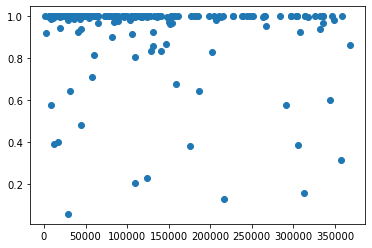

In [22]:
# What percentage of proposals are unanimous?
proposals_df['percentage_for'] = proposals_df['scores'].map(lambda x: x[0])/proposals_df['scores_total']
plt.scatter(proposals_df['scores_total'],proposals_df['percentage_for'])
